In [2]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Concatenate data from all subjects and all sessions
mycwd = os.getcwd()


all_inc = True

if all_inc == True:
    path = r'/home/amoran/YASA/SWSdata/all'
else:
    path = r'/home/amoran/YASA/SWSdata/all_N3'
os.chdir(path)
all_files = glob.glob("*.csv")
df_from_each_file = (pd.read_csv(f) for f in all_files)
newdf =  []
for i, dff in enumerate(df_from_each_file):
    dff['Group']= all_files[i][0]
    dff['Subject'] = all_files[i][0:3]
    dff['Session'] = all_files[i][4]
    newdf.append(dff)

os.chdir(mycwd)

# Construct dataframe
concatenated_df = pd.concat(newdf, ignore_index=True)
concatenated_df.rename(columns={'Unnamed: 0':'Wave'}, inplace=True)
concatenated_df.loc[:,'Session'] = concatenated_df['Session'].astype(int)
concatenated_df.loc[:,'Start'] = concatenated_df['Start']/3600

# Name channels
chan_list = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F3','Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 
             'A1', 'T7', 'C5', 'C3', 'Cz', 'C4', 'C6', 'T8', 'A2', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 
             'P4', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
for i in range(len(chan_list)):
    concatenated_df.loc[(concatenated_df.Channel == 'EEG ' + chan_list[i]), 'Channel'] = chan_list[i]

# Add age
age = pd.read_csv('/home/amoran/YASA/SWSdata/NMDA-cgi1_age.csv', usecols = ['Subject','Session','Birthdate','Testdate'])
age.loc[:,('Birthdate','Testdate')] = age.loc[:,('Birthdate','Testdate')].apply(pd.to_datetime)
age['Age'] = ((age['Testdate']-age['Birthdate']).apply(lambda r:r.days))/365.25
age['Age'] = round(age['Age'],2)
concatenated_df = concatenated_df.merge(age[['Subject','Session','Age']], on = ['Subject','Session'])


# Old/New system
concatenated_df['Machine'] = 'O'

subj1 = ['C22','C23','C21','C25','E17','E18','E20','E21','E22','E24','E25','E26','E27','S15','S16','S17','S18','S19','S20','S21','S22']
subj2 = ['E18','E20','E22']
subj3 = ['E13','E16','E17','E18']
subj4 = ['C13','C14','C15','C16','C20','C21','C23','E09','E10','E11','E13','E14','E15','E16','E18','S07','S08','S11','S12']
concatenated_df.loc[(concatenated_df['Session']==1)&concatenated_df.Subject.isin(subj1), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==2)&concatenated_df.Subject.isin(subj2), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==3)&concatenated_df.Subject.isin(subj3), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==4)&concatenated_df.Subject.isin(subj4), 'Machine'] = 'N'


concatenated_df = concatenated_df.sort_values(by = ['Subject','Session','Start'])

In [4]:
concatenated_df

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine
3026258,0,0.263417,948.93,949.21,949.37,949.52,1.22,-99.451261,40.264333,139.715594,498.984264,0.819672,2,Fp1,0,C,C02,1,22.91,O
3028330,2072,0.263503,948.91,949.11,949.34,949.54,0.93,-47.567302,57.325832,104.893134,524.465670,1.075269,2,Fpz,1,C,C02,1,22.91,O
3049784,23526,0.390594,1406.61,1406.99,1407.54,1407.86,1.72,-41.000357,45.505349,86.505706,227.646594,0.581395,2,FT8,15,C,C02,1,22.91,O
3050525,24267,0.390614,1406.66,1407.04,1407.50,1407.82,1.61,-62.808547,76.158474,138.967022,365.702689,0.621118,2,T7,17,C,C02,1,22.91,O
3051341,25083,0.390683,1406.79,1407.17,1407.61,1407.90,1.44,-71.977917,63.284502,135.262419,355.953733,0.694444,2,C5,18,C,C02,1,22.91,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562937,66872,7.985675,28748.68,28748.90,28749.12,28749.42,0.99,-60.382426,56.412705,116.795131,530.886958,1.010101,2,PO4,38,S,S22,1,18.30,N
2550530,54465,7.986847,28752.99,28753.25,28753.49,28753.86,1.21,-47.168157,36.646719,83.814876,322.364906,0.826446,2,CPz,27,S,S22,1,18.30,N
2556741,60676,7.986847,28753.01,28753.27,28753.51,28753.90,1.25,-49.500273,39.891287,89.391560,343.813691,0.800000,2,Pz,32,S,S22,1,18.30,N
2544035,47970,7.986858,28753.00,28753.25,28753.50,28753.87,1.18,-43.927471,38.041350,81.968821,327.875285,0.847458,2,C4,21,S,S22,1,18.30,N


In [5]:
if all_inc == True:
    concatenated_df.to_pickle('./concatenated_df_oct.pkl')
else:
    concatenated_df.to_pickle('./concatenated_dfn3_oct.pkl')
age.to_pickle('./age_oct.pkl')

In [6]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
data = concatenated_df[crs1]
# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')
# Data all groups sessions 1-4
data4 = concatenated_df[(crs1 | crs2 | crs3 | crs4)]
# Data encephalitis for 4 sessions
cridataE = cri1 & (crs1 | crs2 | crs3 | crs4)
dataE = concatenated_df[cridataE]

/tmp/ipykernel_1761021/2811139589.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ConfArousal'] = 0


In [7]:
# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)

/tmp/ipykernel_1761021/4165211598.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## Check age

In [8]:
age['Group'] = age['Subject'].str[0]
age.tail(9)

,Subject,Session,Birthdate,Testdate,Age,Group
142,E16,4,1961-05-23 00:00:00,2019-07-25 00:00:00,58.17,E
143,E18,4,1993-03-10 00:00:00,2020-02-27 00:00:00,26.97,E
144,S03,4,2000-04-13 00:00:00,2018-07-19 00:00:00,18.26,S
145,S05,4,1986-04-01 00:00:00,2019-11-08 00:00:00,33.60,S
146,S07,4,2002-06-21 00:00:00,2019-03-28 00:00:00,16.77,S
147,S08,4,2003-05-09 00:00:00,2019-03-27 00:00:00,15.88,S
148,S11,4,2003-05-15 00:00:00,2019-11-07 00:00:00,16.48,S
149,S12,4,1998-03-04 00:00:00,2019-09-05 00:00:00,21.51,S
150,S15,4,2000-06-18 00:00:00,2020-02-20 00:00:00,19.67,S


average age: 29.560909090909092
average age controls: 34.118125
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


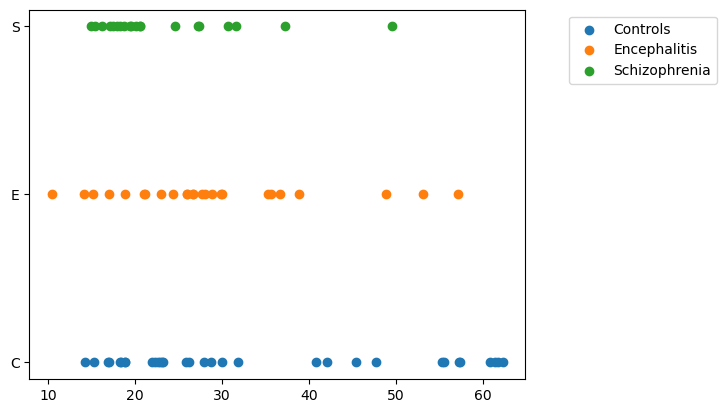

In [9]:
# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

## Individual plots

In [10]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,Position
0,16147,0.390689,1406.81,1407.16,1407.77,1408.12,1.64,-54.438037,56.538966,110.977003,...,0.609756,2,F4,9,C,C02,1,22.91,O,F
1,11458,0.391044,1408.03,1408.31,1408.67,1409.26,1.50,-59.791872,41.681846,101.473718,...,0.666667,2,F7,6,C,C02,1,22.91,O,F
2,14355,0.393181,1415.75,1416.35,1416.68,1416.93,1.48,-43.574775,38.377907,81.952683,...,0.675676,2,Fz,8,C,C02,1,22.91,O,F
3,11459,0.393536,1417.03,1417.28,1417.47,1417.69,0.96,-82.223783,45.544797,127.768579,...,1.041667,2,F7,6,C,C02,1,22.91,O,F
4,14356,0.397639,1431.74,1431.96,1432.18,1432.82,1.32,-42.860329,34.949432,77.809761,...,0.757576,2,Fz,8,C,C02,1,22.91,O,F


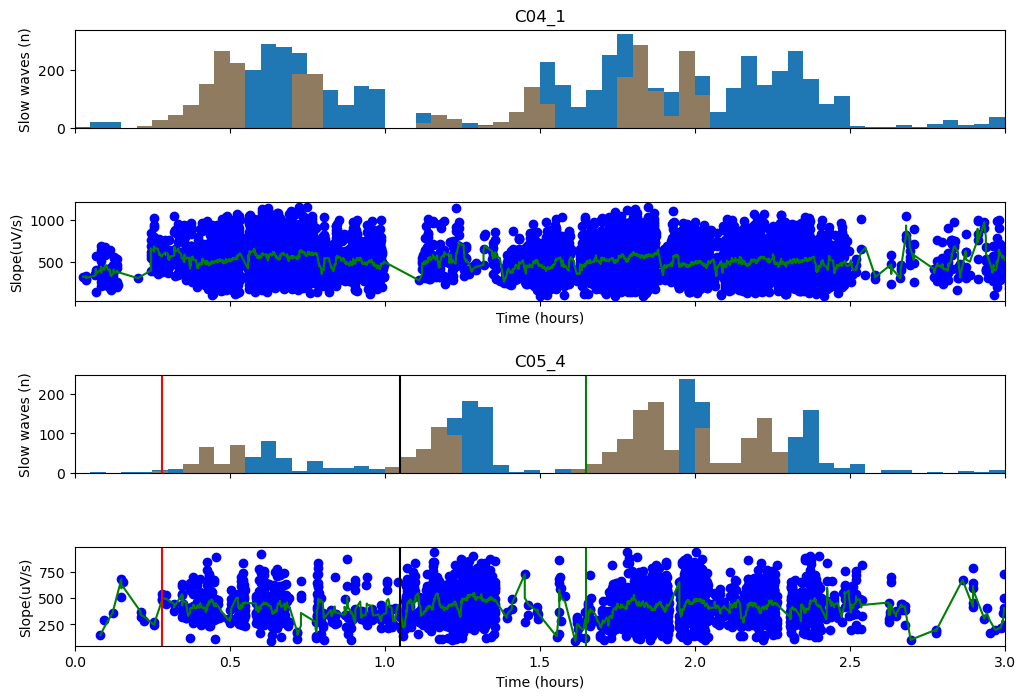

In [11]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

num_subplots = 2

# Create a figure and subplots
fig, axs = plt.subplots(2*num_subplots, 1, figsize=(12, 4*num_subplots), sharex = True, gridspec_kw={'hspace': 0.75})

c = 0
for idx, (name, Subject) in enumerate(data_F.groupby('Id')):
    if name == 'C04_1' or name == 'C05_4':
        Subject = Subject.sort_values(by=['Start']).reset_index(drop=True)
        Subject['Time'] = pd.to_datetime(Subject['Start'],unit = 'h')
        Subject = Subject.set_index('Time')
        rmean = Subject.Slope.rolling('60s').mean()

        
        axs[c].set_title(name)
        binBoundaries = np.arange(0,10,0.05)
        Subject_n3 = Subject[Subject['Stage']==3]
        axs[c].hist(Subject['Start'],bins=binBoundaries,alpha = 1)
        axs[c].hist(Subject_n3['Start'],bins=binBoundaries,alpha=0.5)
        axs[c].set_ylabel('Slow waves (n)')

        


        axs[c].set_xlim([0, 3])

        c = c + 1

        axs[c].scatter(Subject['Start'],Subject['Slope'],color='blue')
        x, mean = zip(*sorted(zip(Subject['Start'], rmean),key=lambda x: x[0]))
        axs[c].plot(x, mean, color='green')
        axs[c].set_ylabel('Slope(uV/s)')
        axs[c].set_xlabel('Time (hours)')
        axs[c].set_xlim([0, 3])

        if name == 'C07_1':
            axs[c].axvline(0.245, color = 'red')
            axs[c-1].axvline(0.245, color = 'red')
            axs[c].axvline(0.254, color = 'black')
            axs[c-1].axvline(0.254, color = 'black')
            axs[c].axvline(1.356, color = 'green')
            axs[c-1].axvline(1.356, color = 'green')
        
        if name == 'C05_4':
            axs[c].axvline(0.28, color = 'red')
            axs[c-1].axvline(0.28, color = 'red')
            axs[c].axvline(1.05, color = 'black')
            axs[c-1].axvline(1.05, color = 'black')
            axs[c].axvline(1.65, color = 'green')
            axs[c-1].axvline(1.65, color = 'green')

        c = c + 1

    
plt.savefig('hist')

    

    

In [12]:
dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
dataC11 = dataC11.set_index('Time')
dataC11

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal
Time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:19:34.750000000,8285,0.326319,1174.97,1175.24,1175.54,1175.91,1.16,-58.165134,48.004513,106.169647,...,0.862069,2,AF7,3,C,C11,1,16.88,O,1
1970-01-01 00:19:36.520000000,13626,0.326811,1176.82,1177.07,1177.24,1177.40,0.88,-71.782545,37.325789,109.108335,...,1.136364,2,AF8,5,C,C11,1,16.88,O,1
1970-01-01 00:20:07.510000000,5703,0.335419,1208.20,1208.44,1208.63,1208.83,1.32,-46.326606,31.601824,77.928431,...,0.757576,2,Fp2,2,C,C11,1,16.88,O,1
1970-01-01 00:20:55.569999999,8286,0.348769,1255.97,1256.37,1256.67,1256.96,1.39,-61.387916,31.949954,93.337870,...,0.719424,2,AF7,3,C,C11,1,16.88,O,1
1970-01-01 00:21:11.339999999,15831,0.353150,1271.89,1272.22,1272.54,1272.86,1.52,-41.785919,55.418799,97.204718,...,0.657895,2,F7,6,C,C11,1,16.88,O,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 08:41:39.420000000,52356,8.694283,31300.12,31300.35,31300.47,31300.56,1.14,-66.102320,25.395312,91.497632,...,0.877193,2,Pz,32,C,C11,1,16.88,O,1
1970-01-01 08:41:46.020000000,56930,8.696117,31307.03,31307.33,31307.59,31307.88,1.86,-53.733592,58.592172,112.325764,...,0.537634,2,O2,42,C,C11,1,16.88,O,1
1970-01-01 08:41:47.770000000,46957,8.696603,31308.00,31308.23,31308.52,31309.14,1.37,-47.716469,54.885270,102.601738,...,0.729927,2,CP3,26,C,C11,1,16.88,O,1


In [13]:
dataC11.Slope.rolling('1000s').mean()

Time
1970-01-01 00:19:34.750000000    393.220915
1970-01-01 00:19:36.520000000    414.827127
1970-01-01 00:20:07.510000000    384.785350
1970-01-01 00:20:55.569999999    346.925181
1970-01-01 00:21:11.339999999    336.452095
                                    ...    
1970-01-01 08:41:39.420000000    428.613663
1970-01-01 08:41:46.020000000    428.433015
1970-01-01 08:41:47.770000000    428.491691
1970-01-01 08:41:51.730000000    428.028331
1970-01-01 08:41:51.770000000    427.470469
Name: Slope, Length: 56931, dtype: float64

<Figure size 2500x500 with 0 Axes>

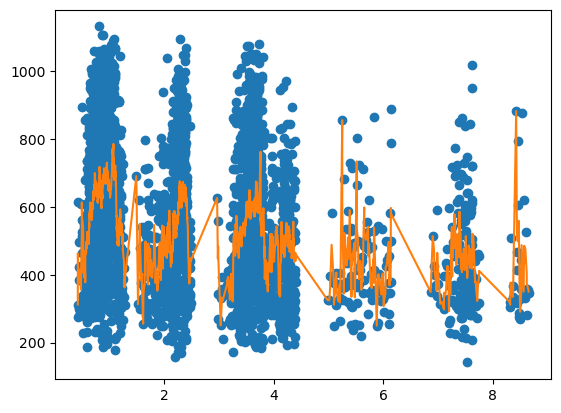

<Figure size 2500x500 with 0 Axes>

In [14]:
dataC11Fz = dataC11[dataC11['Channel'] == 'Fz']
rmean1Fz = dataC11Fz.Slope.rolling('100s').mean()
plt.scatter(dataC11Fz['Start'], dataC11Fz['Slope'])
x, mean = zip(*sorted(zip(dataC11Fz['Start'], rmean1Fz),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))


<Figure size 2500x500 with 0 Axes>

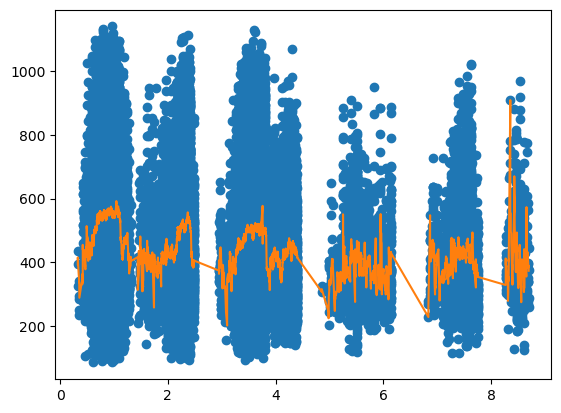

<Figure size 2500x500 with 0 Axes>

In [15]:
rmean1 = dataC11.Slope.rolling('100s').mean()
plt.scatter(dataC11['Start'], dataC11['Slope'])
x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))

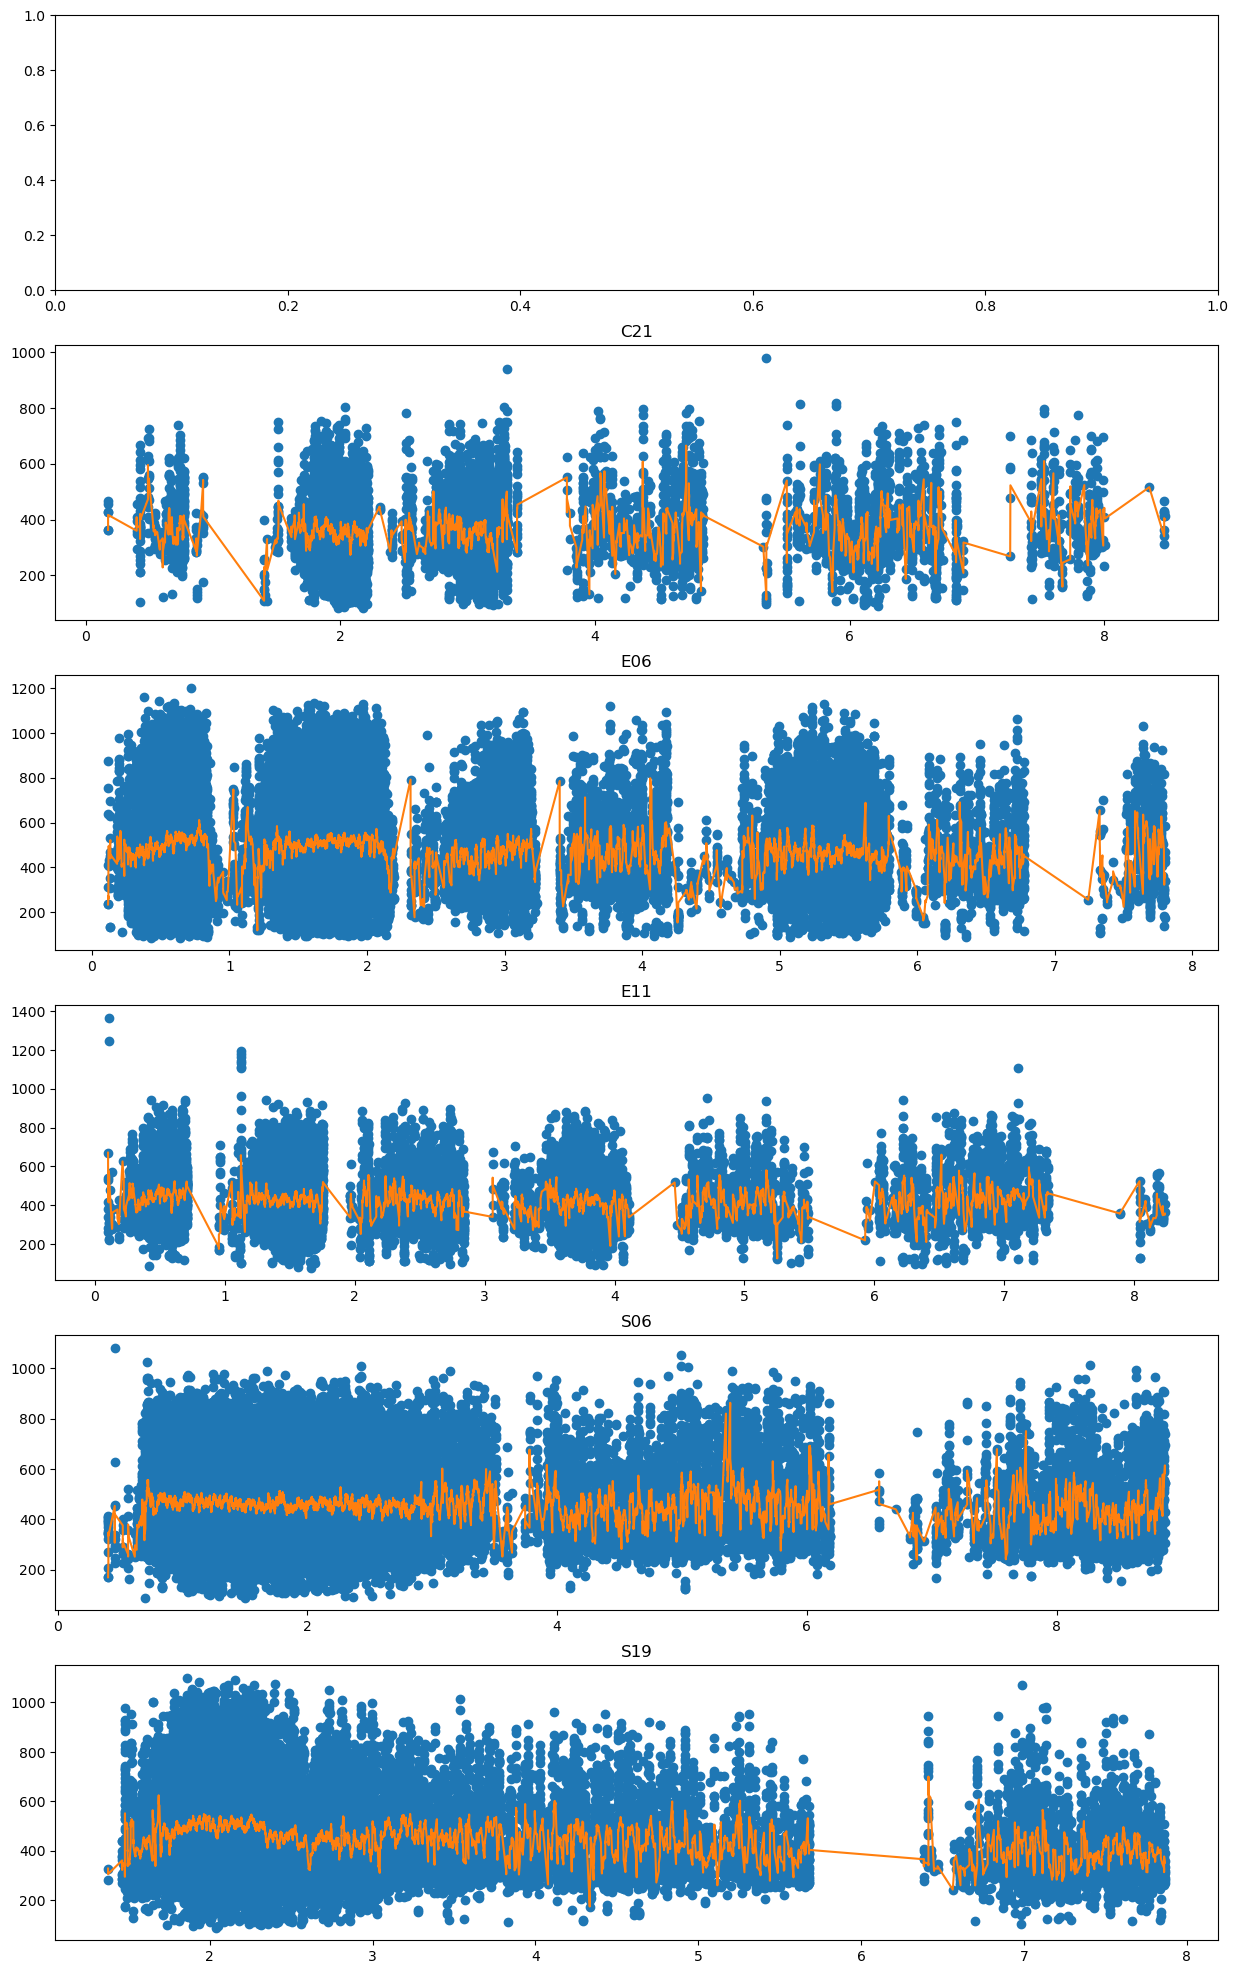

In [16]:
fig, ax = plt.subplots(6, 1, figsize = (15, 25))

### DATA
#dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
#dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
#dataC11 = dataC11.set_index('Time')
#rmean1 = dataC11.Slope.rolling('60s').mean()
dataC21 = data[data['Subject']=='C21'].sort_values(by=['Start']).reset_index(drop=True)
dataC21['Time'] = pd.to_datetime(dataC21['Start'],unit = 'h')
dataC21 = dataC21.set_index('Time')
rmean2 = dataC21.Slope.rolling('60s').mean()
dataE06 = data[data['Subject']=='E06'].sort_values(by=['Start']).reset_index(drop=True)
dataE06['Time'] = pd.to_datetime(dataE06['Start'],unit = 'h')
dataE06 = dataE06.set_index('Time')
rmean3 = dataE06.Slope.rolling('60s').mean()
dataE11 = data[data['Subject']=='E11'].sort_values(by=['Start']).reset_index(drop=True)
dataE11['Time'] = pd.to_datetime(dataE11['Start'],unit = 'h')
dataE11 = dataE11.set_index('Time')
rmean4 = dataE11.Slope.rolling('60s').mean()
dataS06 = data[data['Subject']=='S06'].sort_values(by=['Start']).reset_index(drop=True)
dataS06['Time'] = pd.to_datetime(dataS06['Start'],unit = 'h')
dataS06 = dataS06.set_index('Time')
rmean5 = dataS06.Slope.rolling('60s').mean()
dataS19 = data[data['Subject']=='S19'].sort_values(by=['Start']).reset_index(drop=True)
dataS19['Time'] = pd.to_datetime(dataS19['Start'],unit = 'h')
dataS19 = dataS19.set_index('Time')
rmean6 = dataS19.Slope.rolling('60s').mean()

# Plot individuals with running mean
#ax[0].set_title('C11')
#ax[0].scatter(dataC11['Start'], dataC11['Slope'])
#x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
#ax[0].plot(x, mean, color='C1')

ax[1].set_title('C21')
ax[1].scatter(dataC21['Start'], dataC21['Slope'])
x, mean = zip(*sorted(zip(dataC21['Start'], rmean2),key=lambda x: x[0]))
ax[1].plot(x, mean, color='C1')

ax[2].set_title('E06')
ax[2].scatter(dataE06['Start'], dataE06['Slope'])
x, mean = zip(*sorted(zip(dataE06['Start'], rmean3),key=lambda x: x[0]))
ax[2].plot(x, mean, color='C1')

ax[3].set_title('E11')
ax[3].scatter(dataE11['Start'], dataE11['Slope'])
x, mean = zip(*sorted(zip(dataE11['Start'], rmean4),key=lambda x: x[0]))
ax[3].plot(x, mean, color='C1')

ax[4].set_title('S06')
ax[4].scatter(dataS06['Start'], dataS06['Slope'])
x, mean = zip(*sorted(zip(dataS06['Start'], rmean5),key=lambda x: x[0]))
ax[4].plot(x, mean, color='C1')

ax[5].set_title('S19')
ax[5].scatter(dataS19['Start'], dataS19['Slope'])
x, mean = zip(*sorted(zip(dataS19['Start'], rmean6),key=lambda x: x[0]))
ax[5].plot(x, mean, color='C1')